In [1]:
using LinearMaps

In [2]:
using LinearAlgebra
import LinearAlgebra: ldiv!, mul!, *, \

In [4]:
using ViscousFlow

In [174]:
using Plots
pyplot()
clibrary(:colorbrewer)
default(grid = false)

┌ Info: Recompiling stale cache file /Users/jeff/.julia/compiled/v1.2/Plots/ld3vC.ji for Plots [91a5bcdd-55d7-5caf-9e0b-520d859cae80]
└ @ Base loading.jl:1240
┌ Info: Recompiling stale cache file /Users/jeff/.julia/compiled/v1.2/PyPlot/oatAj.ji for PyPlot [d330b81b-6aea-500a-939a-2ce795aea3ee]
└ @ Base loading.jl:1240


## New functions

In [5]:
struct SaddleSystem{T,Ns,Nc}
    A :: LinearMap{T}
    B₁ᵀ :: LinearMap{T}
    B₂ :: LinearMap{T}
    C :: LinearMap{T}
    A⁻¹ :: LinearMap{T}
    A⁻¹B₁ᵀf :: Vector{T}
    B₂A⁻¹r₁ :: Vector{T}
    _u_buf :: Vector{T}
    _f_buf :: Vector{T}
    S :: LinearMap{T}
    S⁻¹ :: LinearMap{T}
end

- SaddleSystem should return an operator for `\`

In [159]:
function SaddleSystem(A::LinearMap{T},B₁ᵀ::LinearMap{T},B₂::LinearMap{T},C::LinearMap{T},
                      A⁻¹::LinearMap{T}) where {T}
    
    ns, nc = _check_sizes(A,B₁ᵀ,B₂,C)
    
    S = C - B₂*A⁻¹*B₁ᵀ
    #S = LinearMap{Float64}(x -> C*x - B₂*(A⁻¹*(B₁ᵀ*x)),length(f));
    Sfact = factorize(Matrix(S))
    S⁻¹ = LinearMap{T}(x -> Sfact\x,nc)
    
    return SaddleSystem{T,ns,nc}(A,B₁ᵀ,B₂,C,A⁻¹,zeros(T,ns),zeros(T,nc),zeros(T,ns),zeros(T,nc),S,S⁻¹)
end

SaddleSystem

In [7]:
function _check_sizes(A,B₁ᵀ,B₂,C)
    mA, nA = size(A)
    mB1, nB1 = size(B₁ᵀ)
    mB2, nB2 = size(B₂)
    mC, nC = size(C)
    
    # check compatibility of sizes
    mA == nA  || error("A is not square")
    mA == mB1 || error("Incompatible number of rows in A and B₁ᵀ")
    nA == nB2 || error("Incompatible number of columns in A and B₂")
    mC == mB2 || error("Incompatible number of rows in C and B₂")
    nC == nB1 || error("Incompatible number of columns in C and B₁ᵀ")
    
    ns = nA
    nc = nB1
    
    return ns, nc
end

_check_sizes (generic function with 1 method)

In [8]:
function _split_vector(x,Ns,Nc)
    return view(x,1:Ns), view(x,Ns+1:Ns+Nc)
end

_split_vector (generic function with 1 method)

In [98]:
function mul!(output::Tuple{AbstractVector{T},AbstractVector{T}},sys::SaddleSystem{T,Ns,Nc},input::Tuple{AbstractVector{T},AbstractVector{T}}) where {T,Ns,Nc}
    u,f = input 
    r₁,r₂ = output
    length(u) == length(r₁) == Ns || error("Incompatible number of elements")
    length(f) == length(r₂) == Nc || error("Incompatible number of elements")
    
    r₁ .= sys.A*u + sys.B₁ᵀ*f
    r₂ .= sys.B₂*u + sys.C*f
    return output
end

mul! (generic function with 196 methods)

In [281]:
function mul!(sol::Tuple{TU,TF},sys::SaddleSystem,rhs::Tuple{TU,TF}) where {T,Ns,Nc,TU,TF}
    u, f = sol
    r₁, r₂ = rhs
    return mul!((_unwrap_vec(u),_unwrap_vec(f)),sys,(_unwrap_vec(r₁),_unwrap_vec(r₂)))
end

mul! (generic function with 198 methods)

In [224]:
function (*)(sys::SaddleSystem,input::Tuple)
    u, f = input
    output = (similar(u),similar(f))
    mul!(output,sys,input)
    return output 
end

* (generic function with 497 methods)

In [222]:
# Routine for accepting vector inputs, parsing it into Ns and Nc parts
function mul!(sol::AbstractVector{T},sys::SaddleSystem{T,Ns,Nc},rhs::AbstractVector{T}) where {T,Ns,Nc}
    mul!(_split_vector(sol,Ns,Nc),sys,_split_vector(rhs,Ns,Nc))
    return sol
end

mul! (generic function with 198 methods)

In [225]:
function (*)(sys::SaddleSystem,input::AbstractVector)
    output = similar(input)
    mul!(output,sys,input)
    return output 
end

* (generic function with 498 methods)

In [10]:
function ldiv!(sol::Tuple{AbstractVector{T},AbstractVector{T}},sys::SaddleSystem{T,Ns,Nc},rhs::Tuple{AbstractVector{T},AbstractVector{T}}) where {T,Ns,Nc}
    
    N = Ns+Nc
    u,f = sol #_split_vector(sol,Ns,Nc)
    r₁,r₂ = rhs #_split_vector(rhs,Ns,Nc)
    length(u) == length(r₁) == Ns || error("Incompatible number of elements")
    length(f) == length(r₂) == Nc || error("Incompatible number of elements")

    u .= sys.A⁻¹*r₁

    sys.B₂A⁻¹r₁ .= sys.B₂*u
    sys._f_buf .= r₂
    sys._f_buf .-= sys.B₂A⁻¹r₁
    
    if Nc > 0
        f .= sys.S⁻¹*sys._f_buf
        #f .= sys.P(f)
    end
    sys.A⁻¹B₁ᵀf .= sys.A⁻¹*sys.B₁ᵀ*f
    u .-= sys.A⁻¹B₁ᵀf
    
    return sol
end

ldiv! (generic function with 125 methods)

In [282]:
function ldiv!(sol::Tuple{TU,TF},sys::SaddleSystem,rhs::Tuple{TU,TF}) where {T,Ns,Nc,TU,TF}
    u, f = sol
    r₁, r₂ = rhs
    return ldiv!((_unwrap_vec(u),_unwrap_vec(f)),sys,(_unwrap_vec(r₁),_unwrap_vec(r₂)))
end

ldiv! (generic function with 127 methods)

In [183]:
function (\)(sys::SaddleSystem,input::Tuple) where {T,Ns,Nc}
    u, f = input
    sol = (similar(u),similar(f))
    ldiv!(sol,sys,input)
    return sol
end

\ (generic function with 191 methods)

In [228]:
# Routine for accepting vector inputs, parsing it into Ns and Nc parts
function ldiv!(sol::AbstractVector{T},sys::SaddleSystem{T,Ns,Nc},rhs::AbstractVector{T}) where {T,Ns,Nc}
    ldiv!(_split_vector(sol,Ns,Nc),sys,_split_vector(rhs,Ns,Nc))
    return sol
end

ldiv! (generic function with 127 methods)

In [227]:
function (\)(sys::SaddleSystem,input::AbstractVector)
    sol = similar(input)
    ldiv!(sol,sys,input)
    return sol 
end

\ (generic function with 192 methods)

In [11]:
function SaddleSystem(A::AbstractMatrix{T},B₁ᵀ::AbstractMatrix{T},
                      B₂::AbstractMatrix{T},C::AbstractMatrix{T}) where {T}
    
    Afact = factorize(A)
    Ainv = LinearMap{T}(x -> Afact\x,size(A,1))
    
    return SaddleSystem(LinearMap{T}(A),LinearMap{T}(B₁ᵀ),
                        LinearMap{T}(B₂),LinearMap{T}(C),Ainv)
end

SaddleSystem

In [12]:
# For cases in which C is zero, no need to pass along the argument
SaddleSystem(A::AbstractMatrix{T},B₁ᵀ::AbstractMatrix{T},B₂::AbstractMatrix{T}) where {T} = 
        SaddleSystem(A,B₁ᵀ,B₂,zeros(T,size(B₂,1),size(B₁ᵀ,2)))

SaddleSystem

In [13]:
# for a given function of function-like object A, which acts upon data of type u
# and returns data of type f
# return a LinearMap that acts upon a vector form of u
linear_map(A,u,f;eltype=Float64) = _linear_map(A,u,f,eltype)
linear_map(A,u;eltype=Float64) = _linear_map(A,u,eltype)
linear_map(A::AbstractMatrix{T},u::AbstractVector{T};eltype=Float64) where {T} = LinearMap{eltype}(A)

linear_map (generic function with 3 methods)

In [14]:
_linear_map(A,input,output,eltype) = LinearMap{eltype}(_create_fcn(A,input),length(output),length(input))
_linear_map(A,input,eltype) = LinearMap{eltype}(_create_fcn(A,input),length(input))

_linear_map (generic function with 2 methods)

In [15]:
function _create_fcn(A,input)
    if hasmethod(*,Tuple{typeof(A),typeof(input)})
        fcn = _create_vec_multiplication(A,input)
    elseif hasmethod(A,Tuple{typeof(input)})
        fcn = _create_vec_function(A,input)
    end
    return fcn
end

_create_fcn (generic function with 1 method)

In [18]:
_create_vec_multiplication(A,u::TU) where {TU} = (x -> vec(A*_wrap_vec(x,u)))
_create_vec_function(A,u::TU) where {TU} = (x -> vec(A(_wrap_vec(x,u))))
_create_vec_backslash(A,u::TU) where {TU} = (x -> vec(A\_wrap_vec(x,u)))

_create_vec_backslash (generic function with 1 method)

In [210]:
_wrap_vec(x::Vector{T},u::TU) where {T,TU} = TU(reshape(x,size(u)...))
_wrap_vec(x::Base.ReshapedArray,u::TU) where {TU} = parent(x)
_wrap_vec(x::AbstractVector{T},u::TU) where {T,TU} = x
_wrap_vec(x,u::TU) where {TU <: Tuple} = x

_wrap_vec (generic function with 4 methods)

In [280]:
_unwrap_vec(x) = vec(x)
_unwrap_vec(x::Tuple) = x

_unwrap_vec (generic function with 2 methods)

In [209]:
# If operator A is a saddle point system, then it accepts tuple inputs
# Need to get it is to accept vector inputs.

Tuple{Array{Float64,1},Array{Float64,1}}

In [20]:
function linear_inverse_map(A,input;eltype=Float64)
    hasmethod(\,Tuple{typeof(A),typeof(input)}) || error("No such backslash operator exists")
    return LinearMap{eltype}(_create_vec_backslash(A,input),length(input))
end

linear_inverse_map (generic function with 1 method)

In [21]:
# This version should take in functions or function-like objects that act upon given
# data types u and f. Should transform them into operators that act on abstract vectors
# of the same size
# There should already be an \ operator associated with A
function SaddleSystem(A,B₁ᵀ,B₂,C,u::TU,f::TF;eltype=Float64) where {TU,TF}
    
    return SaddleSystem(linear_map(A,u,eltype=eltype),linear_map(B₁ᵀ,f,u,eltype=eltype),
                        linear_map(B₂,u,f,eltype=eltype),linear_map(C,f,eltype=eltype),
                        linear_inverse_map(A,u,eltype=eltype))
end

SaddleSystem

In [22]:
SaddleSystem(A,B₁ᵀ,B₂,u::TU,f::TF;eltype=Float64) where {TU,TF} = SaddleSystem(A,B₁ᵀ,B₂,zeros(eltype,length(f),length(f)),u,f,eltype=eltype)

SaddleSystem

### Test on matrices

In [283]:
A1 = Float64[1 2; 2 1]
B2 = Float64[2 3;-1 -1]
B1 = Float64[2 3;-1 -1]'
C = Matrix{Float64}(undef,2,2)
C.= [5 -2; 3 -4];

In [284]:
A = SaddleSystem(A1,B1,B2,C);

In [285]:
rhs = ([1.0,2.0],[3.0,4.0]);
sol = (zeros(2),zeros(2));

In [286]:
@time ldiv!(sol,A,rhs)

  0.000034 seconds (20 allocations: 912 bytes)


([-4.440892098500626e-16, -0.35714285714285704], [0.6428571428571431, -0.42857142857142827])

In [288]:
@time sol = A\rhs

  0.000032 seconds (23 allocations: 1.109 KiB)


([-4.440892098500626e-16, -0.35714285714285704], [0.6428571428571431, -0.42857142857142827])

In [289]:
A*sol

([0.9999999999999999, 1.9999999999999998], [3.0, 4.0])

#### Test with vector inputs/outputs

In [290]:
rhs1, rhs2 = rhs
rhsvec = [rhs1;rhs2]
solvec = similar(rhsvec);

In [291]:
solvec = A\rhsvec;

In [292]:
A*solvec

4-element Array{Float64,1}:
 0.9999999999999999
 1.9999999999999998
 3.0               
 4.0               

### Test on ViscousFlow operators

In [293]:
nx = 130; ny = 130;
Lx = 2.0;
dx = Lx/(nx-2);
w = Nodes(Dual,(nx,ny));
u = similar(w);

In [294]:
wvec = vec(w);

In [295]:
L = plan_laplacian(size(w),with_inverse=true)

Discrete Laplacian (and inverse) on a (nx = 130, ny = 130) grid acting on Float64 data with spacing 1.0

In [296]:
w .= rand(size(w)...);

In [297]:
uvec = zeros(length(w));

In [298]:
@time _wrap_vec(wvec,w);

  0.001855 seconds (730 allocations: 43.772 KiB)


In [299]:
Lop = linear_map(L,w);

In [300]:
@time u = L*w;

  0.000145 seconds (8 allocations: 132.344 KiB)


In [301]:
@time uvec = Lop*wvec;

  0.007467 seconds (7.41 k allocations: 536.840 KiB)


In [302]:
_wrap_vec(uvec,u) == u

true

In [303]:
Linv = linear_inverse_map(L,w);

In [304]:
@time yvec = Linv*wvec;

  0.009284 seconds (11.77 k allocations: 714.122 KiB)


In [305]:
@time y = L\w;

  0.001091 seconds (8 allocations: 132.344 KiB)


In [306]:
_wrap_vec(yvec,y) == y

true

In [307]:
n = 128;
θ = range(0,stop=2π,length=n+1);
R = 0.5;
xb = 1.0 .+ R*cos.(θ)
yb = 1.0 .+ R*sin.(θ)
ds = (2π/n)*R;
X = VectorData(xb[1:n],yb[1:n]);
f = ScalarData(X);

In [308]:
fvec = vec(f);

In [309]:
E = Regularize(X,dx;issymmetric=true)
Hmat,Emat = RegularizationMatrix(E,f,w);

In [310]:
f[10] = 1.0;

In [311]:
Hop = linear_map(Hmat,f,w);

In [312]:
@time y = Hmat*f;

  0.000094 seconds (8 allocations: 132.344 KiB)


In [313]:
@time yvec = Hop*fvec;

  0.007524 seconds (7.68 k allocations: 554.130 KiB)


In [314]:
_wrap_vec(yvec,y) == y

true

In [315]:
Eop = linear_map(Emat,w,f);

In [316]:
@time g = Emat*w;

  0.000019 seconds (6 allocations: 1.313 KiB)


In [317]:
@time gvec = Eop*vec(w);

  0.011697 seconds (7.69 k allocations: 415.182 KiB, 48.07% gc time)


In [318]:
_wrap_vec(gvec,g) == g

true

In [319]:
@time A = SaddleSystem(L,Hmat,Emat,w,f);

  0.440631 seconds (665.47 k allocations: 96.338 MiB, 6.51% gc time)


In [320]:
@time A.S*vec(f);

  0.133008 seconds (436.96 k allocations: 18.857 MiB, 6.09% gc time)


In [321]:
@time A.S⁻¹*vec(f);

  0.008101 seconds (13.97 k allocations: 709.436 KiB)


In [322]:
sol = (vec(zero(w)),vec(zero(f)));

In [323]:
rhs = (vec(w),vec(f));

In [324]:
@time ldiv!(sol,A,rhs);

  0.052022 seconds (123.67 k allocations: 6.075 MiB)


In [328]:
ψb = ScalarData(X);
w = Nodes(Dual,(nx,ny));
ψb .= -(xb[1:n] .- 1);
f .= ones(Float64,n)*ds;
ψ = Nodes(Dual,w);

In [329]:
sol2 = (zero(w),zero(f));
@time ldiv!(sol2,A,(w,ψb));

  0.010709 seconds (14.27 k allocations: 1.338 MiB)


In [330]:
@time ψ,f = A\(w,ψb);

  0.002150 seconds (53 allocations: 797.344 KiB)


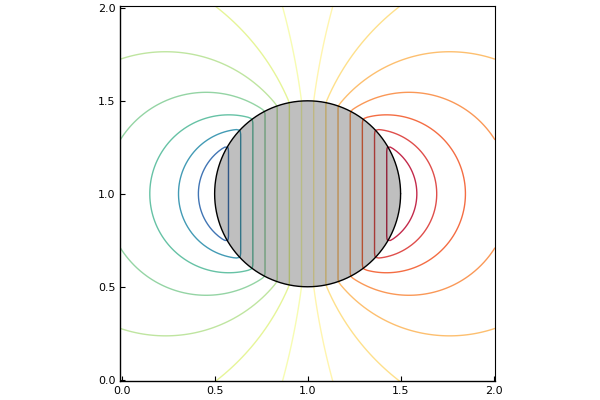

In [331]:
xg,yg = coordinates(ψ,dx=dx)
plot(xg,yg,ψ)
plot!(xb,yb,xlim=(-Inf,Inf),ylim=(-Inf,Inf),fillcolor=:black,fillrange=0,fillalpha=0.25,linecolor=:black)

In [332]:
rhs2 = (similar(w),similar(f));
@time rhs2 = A*sol2;

  0.015032 seconds (16.63 k allocations: 1.344 MiB)


In [338]:
norm(rhs2[2]-ψb)

3.901939054546046e-15

### Saddle system of a saddle system

In [339]:
A1 = Float64[1 2; 2 1]
B21 = Float64[2 3];
B11 = B21';
C1 = Matrix{Float64}(undef,1,1)
C1.= 5

B22 = Float64[-1 -1 3];
B12 = Float64[-1 -1 -2]';
C2 = Matrix{Float64}(undef,1,1)
C2.= -4;

In [340]:
rhs11 = [1.0,2.0];
rhs12 = Vector{Float64}(undef,1)
rhs12 .= 3.0;
#rhs1 = (rhs11,rhs12)
rhs1 = [rhs11;rhs12];

rhs2 = Vector{Float64}(undef,1)
rhs2 .= 4.0;

#sol = ((zero(rhs11),zero(rhs12)),zero(rhs2))
rhs = (rhs1,rhs2);
sol = (zero(rhs1),zero(rhs2));

In [341]:
A = SaddleSystem(A1,B11,B21,C1);

In [342]:
Abig = SaddleSystem(A,B12,B22,C2,rhs1,rhs2);

In [343]:
sol = Abig\rhs

([-4.440892098500626e-16, -0.3571428571428571, 0.6428571428571432], [-0.4285714285714282])

In [344]:
Abig*sol

([1.0, 1.9999999999999998, 3.0000000000000004], [4.0])

#### Pass in as tuples of tuples

In [346]:
rhs11 = [1.0,2.0];
rhs12 = Vector{Float64}(undef,1)
rhs12 .= 3.0
rhs1 = (rhs11,rhs12)

rhs2 = Vector{Float64}(undef,1)
rhs2 .= 4.0;

rhs = (rhs1,rhs2)

sol = ((zero(rhs11),zero(rhs12)),zero(rhs2))

(([0.0, 0.0], [0.0]), [0.0])

In [347]:
A = SaddleSystem(A1,B11,B21,C1);

In [348]:
Abig = SaddleSystem(A,B12,B22,C2,rhs1,rhs2);

UndefVarError: UndefVarError: fcn not defined

In [258]:
x = (1.0,2.0,([2.0,3.0],2.0))

(1.0, 2.0, ([2.0, 3.0], 2.0))

In [259]:
x1, x2 = x

(1.0, 2.0, ([2.0, 3.0], 2.0))

In [269]:
@time z = Iterators.flatten((w,f))

  0.000010 seconds (7 allocations: 256 bytes)


Base.Iterators.Flatten{Tuple{Nodes{Dual,130,130,Float64},ScalarData{128,Float64}}}((Dual nodes in a (nx = 130, ny = 130) cell grid of type Float64 data
  Number of Dual nodes: (nx = 130, ny = 130), [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]))

In [279]:
x

(1.0, 2.0, ([2.0, 3.0], 2.0))

In [273]:
fieldnames(typeof(z))

(:it,)

In [277]:
@time collect(z)

  0.000351 seconds (19 allocations: 512.859 KiB)


17028-element Array{Float64,1}:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮  
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0